In [69]:
from pathlib import Path
import re

import scope
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.3, palette="Paired")
plt.rcParams['figure.dpi'] = 300

In [70]:
def _read_float_file(path: Path, cutoff=200, min_length=None):
    reader = scope.Reader(path)
    steps, episode_scores = reader['episode/score']
    if min_length is not None:
        actual_steps = [steps[i] - (steps[i-1] if i > 0 else 0) for i in range(len(steps))]
        episode_scores = [score for i, score in enumerate(episode_scores) if actual_steps[i] >= min_length]
    
    if len(episode_scores) < cutoff:
        print(f"Warning: {path} has only {len(episode_scores)} episodes, less than the cutoff of {cutoff}.")
    return np.asarray(episode_scores)[:cutoff]

def plot_maniskill(files_labels=[], output=None):
    plt.figure(figsize=(10, 6))

    bars = []
    labels = []
    hue = []
    for path, label in files_labels:
        bars.append(_read_float_file(Path(path)).mean())
        *name, dist = label.split(" ")
        labels.append(" ".join(name))
        hue.append(dist)

    g = sns.catplot(
        kind="bar", x=labels, y=bars, hue=hue,
        errorbar="sd", palette="Set2", alpha=.8, height=6
    )
    g.despine(left=True)

    plt.xlabel("Environment Setting")
    plt.ylabel("Average Reward")
    plt.title(f"Average reward over 200 episodes")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

def plot_carla(files_labels=[], output=None):
    plt.figure(figsize=(10, 6))

    bars = []
    labels = []
    hue = []
    for path, label in files_labels:
        bars.append(_read_float_file(Path(path), cutoff=50, min_length=20).mean())
        *name, dist = label.split(" ")
        labels.append(" ".join(name))
        hue.append(dist)

    g = sns.catplot(
        kind="bar", x=labels, y=bars, hue=hue,
        errorbar="se", palette="Set2", alpha=.8, height=6
    )
    g.despine(left=True)

    plt.xlabel("Environment Setting")
    plt.ylabel("Average Reward")
    plt.title(f"Average reward over 50 episodes")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

[('Baseline', 10.91115521316242, 'ID'), ('Baseline', 10.548903430586797, 'OOD'), ('DINO finetune', 10.886660591497861, 'ID'), ('DINO finetune', 10.163853350208697, 'OOD'), ('DINO Partial', 9.802362432804657, 'ID'), ('DINO Partial', 9.4049647959051, 'OOD'), ('DINO frozen', 9.37123670268617, 'ID'), ('DINO frozen', 8.77676312987227, 'OOD')]


<Figure size 3000x1800 with 0 Axes>

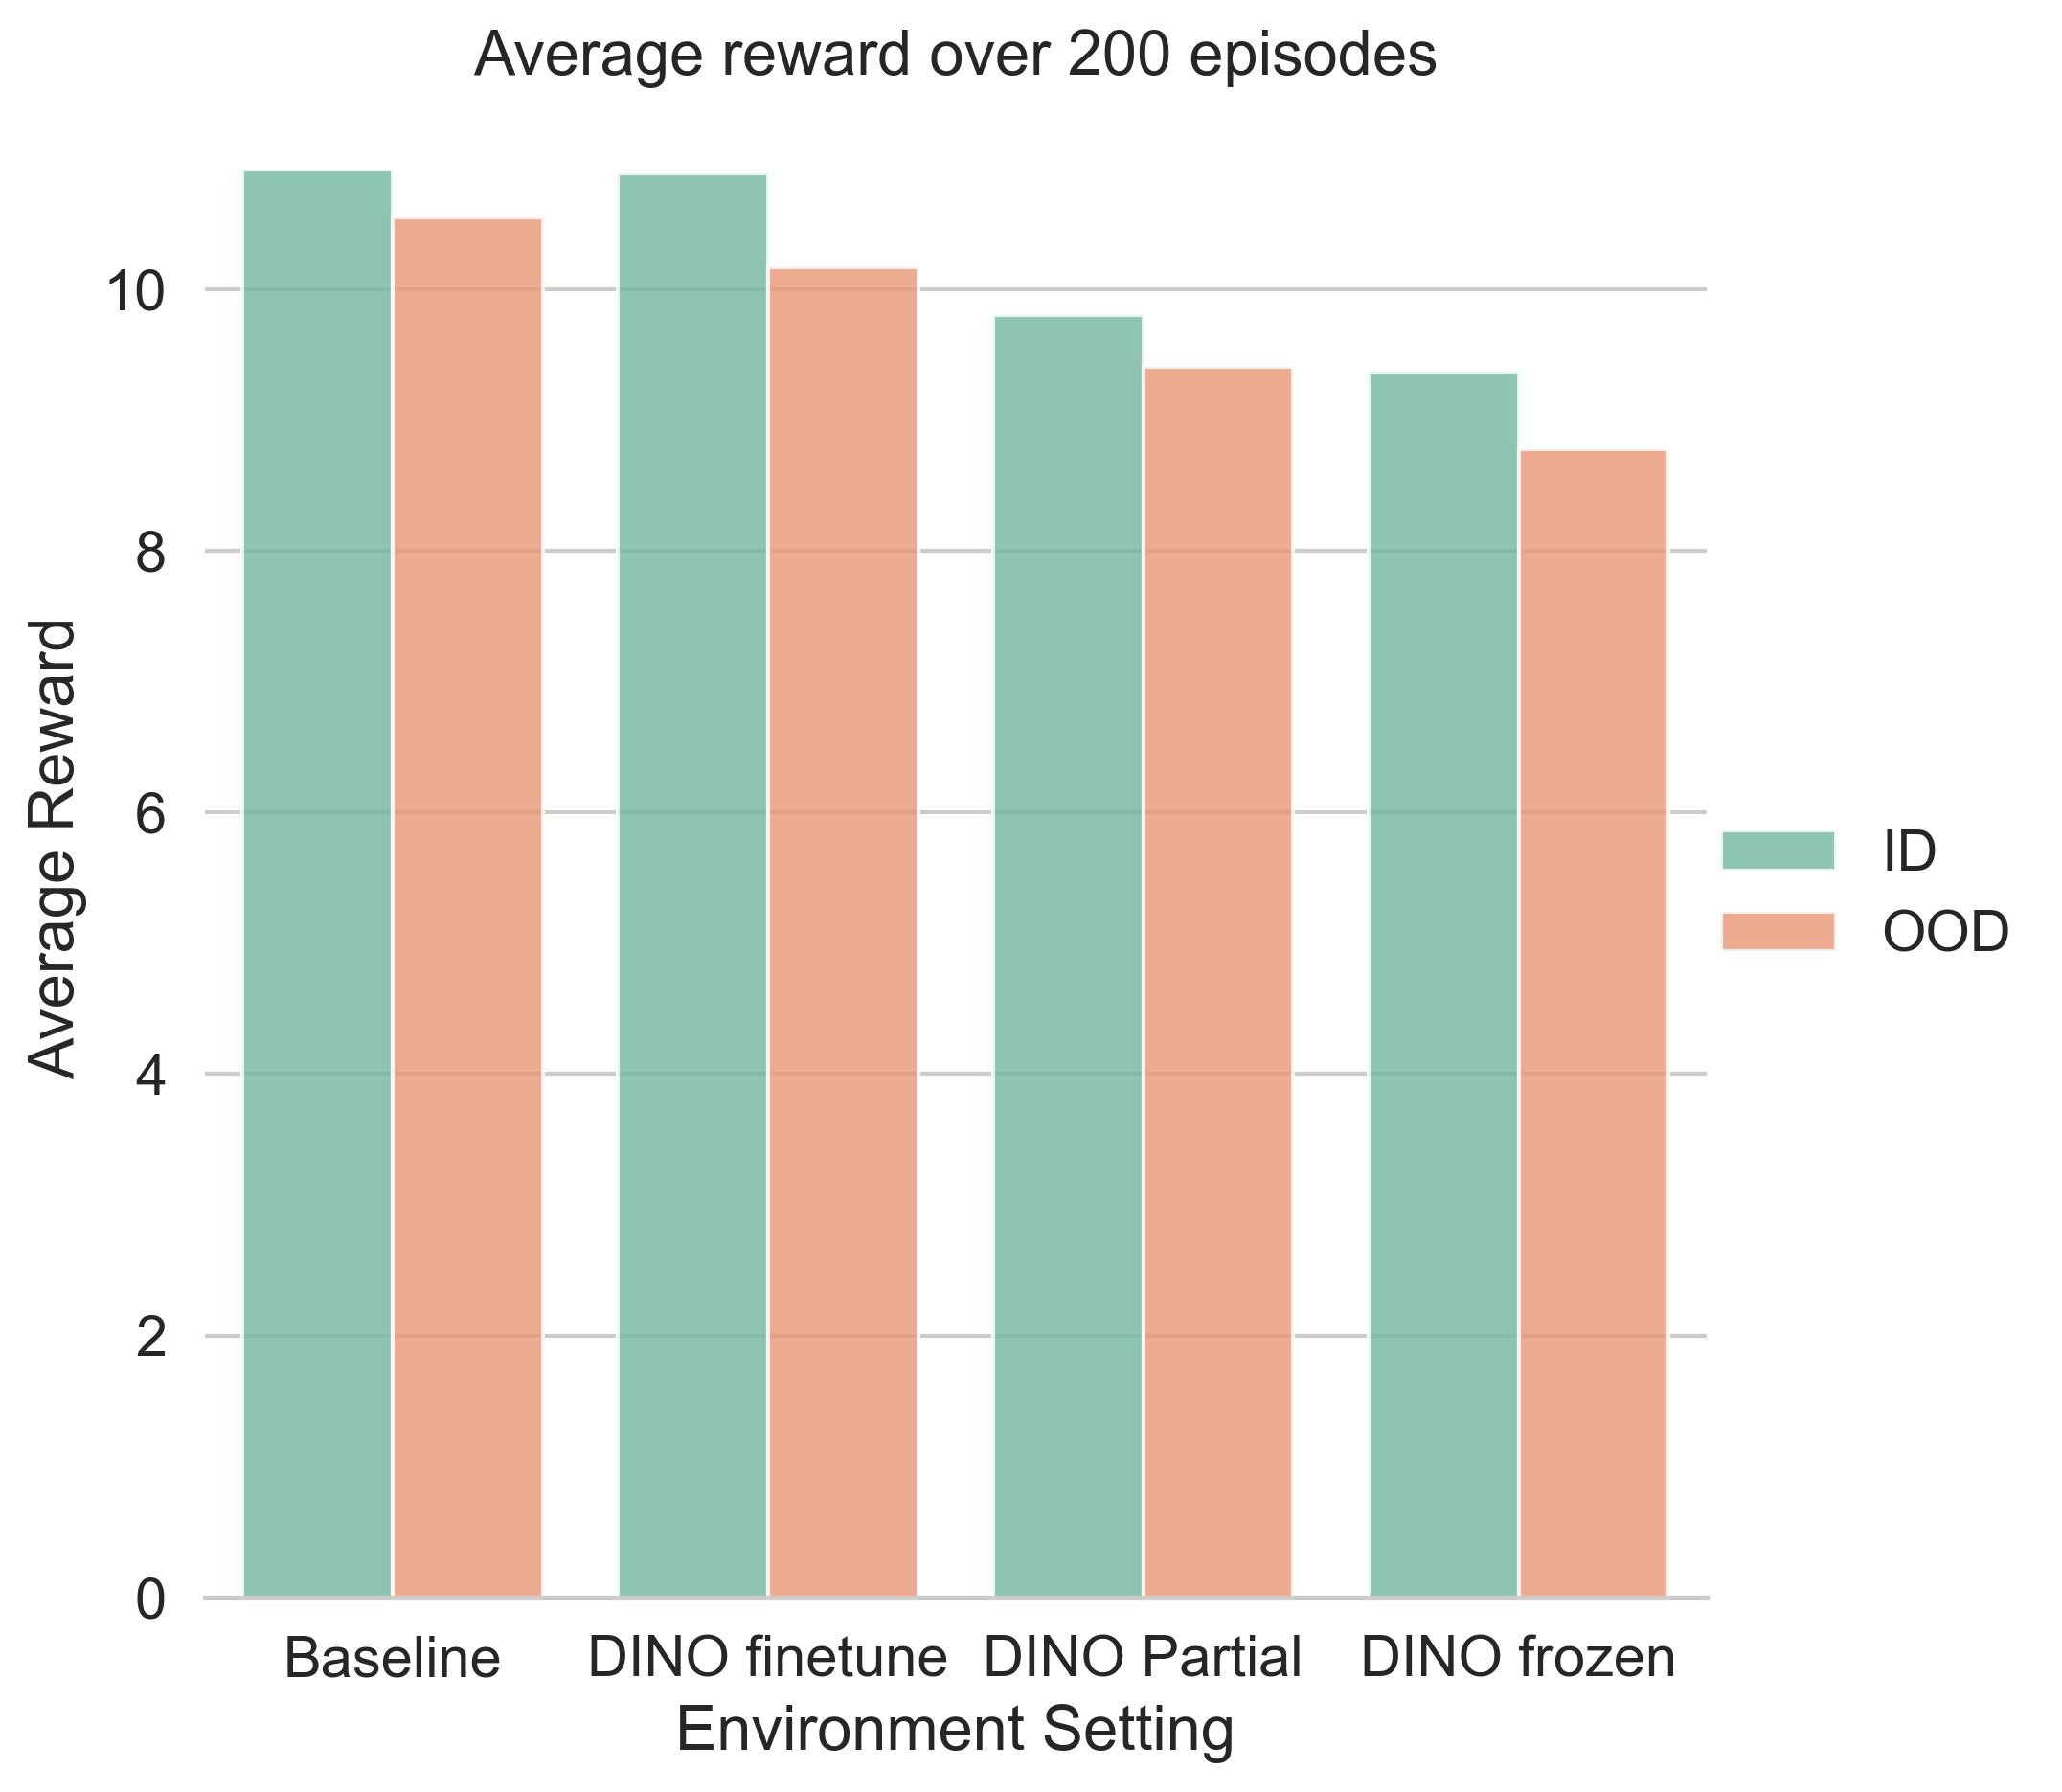

In [35]:
plot_maniskill(
    files_labels=[
        ("logdir/baseline_pick_ycb_eval_ID/", "Baseline ID"),
        ("logdir/baseline_pick_ycb_eval_OOD/", "Baseline OOD"),
        ("logdir/DINOFT_pick_ycb_eval_ID/", "DINO finetune ID"),
        ("logdir/DINOFT_pick_ycb_eval_OOD/", "DINO finetune OOD"),
        ("logdir/DINOPartial_pick_ycb_eval_ID/", "DINO Partial ID"),
        ("logdir/DINOPartial_pick_ycb_eval_OOD/", "DINO Partial OOD"),
        ("logdir/DINOFreeze_pick_ycb_eval_ID/", "DINO frozen ID"),
        ("logdir/DINOFreeze_pick_ycb_eval_OOD/", "DINO frozen OOD"),
    ]
)

[('Baseline', 381.685245255928, 'ID'), ('Baseline', 338.2537648807466, 'ID'), ('Baseline', 474.4303720352997, 'ID'), ('DINO finetune', 214.7607072573193, 'ID'), ('DINO partial', 244.11062613738162, 'ID'), ('DINO frozen', 154.80685229061666, 'ID'), ('Baseline', 62.7518685930036, 'softhighlight'), ('Baseline', 40.902491208910945, 'softhighlight'), ('Baseline', 69.61426082042045, 'softhighlight'), ('DINO finetune', 435.0366029392742, 'softhighlight'), ('DINO finetune', 276.68885518491265, 'softhighlight'), ('DINO finetune', 297.5157962680608, 'softhighlight'), ('DINO partial', 215.21816536231665, 'softhighlight'), ('DINO frozen', 387.9263809698075, 'softhighlight'), ('DINO frozen', 356.33457589305937, 'softhighlight'), ('DINO frozen', 337.3886901159678, 'softhighlight'), ('Baseline', 38.2204160470306, 'softnoisylowlight'), ('Baseline', 20.30670282423496, 'softnoisylowlight'), ('Baseline', 329.4699034582209, 'softnoisylowlight'), ('DINO finetune', 174.02530940031866, 'softnoisylowlight'), 

<Figure size 3000x1800 with 0 Axes>

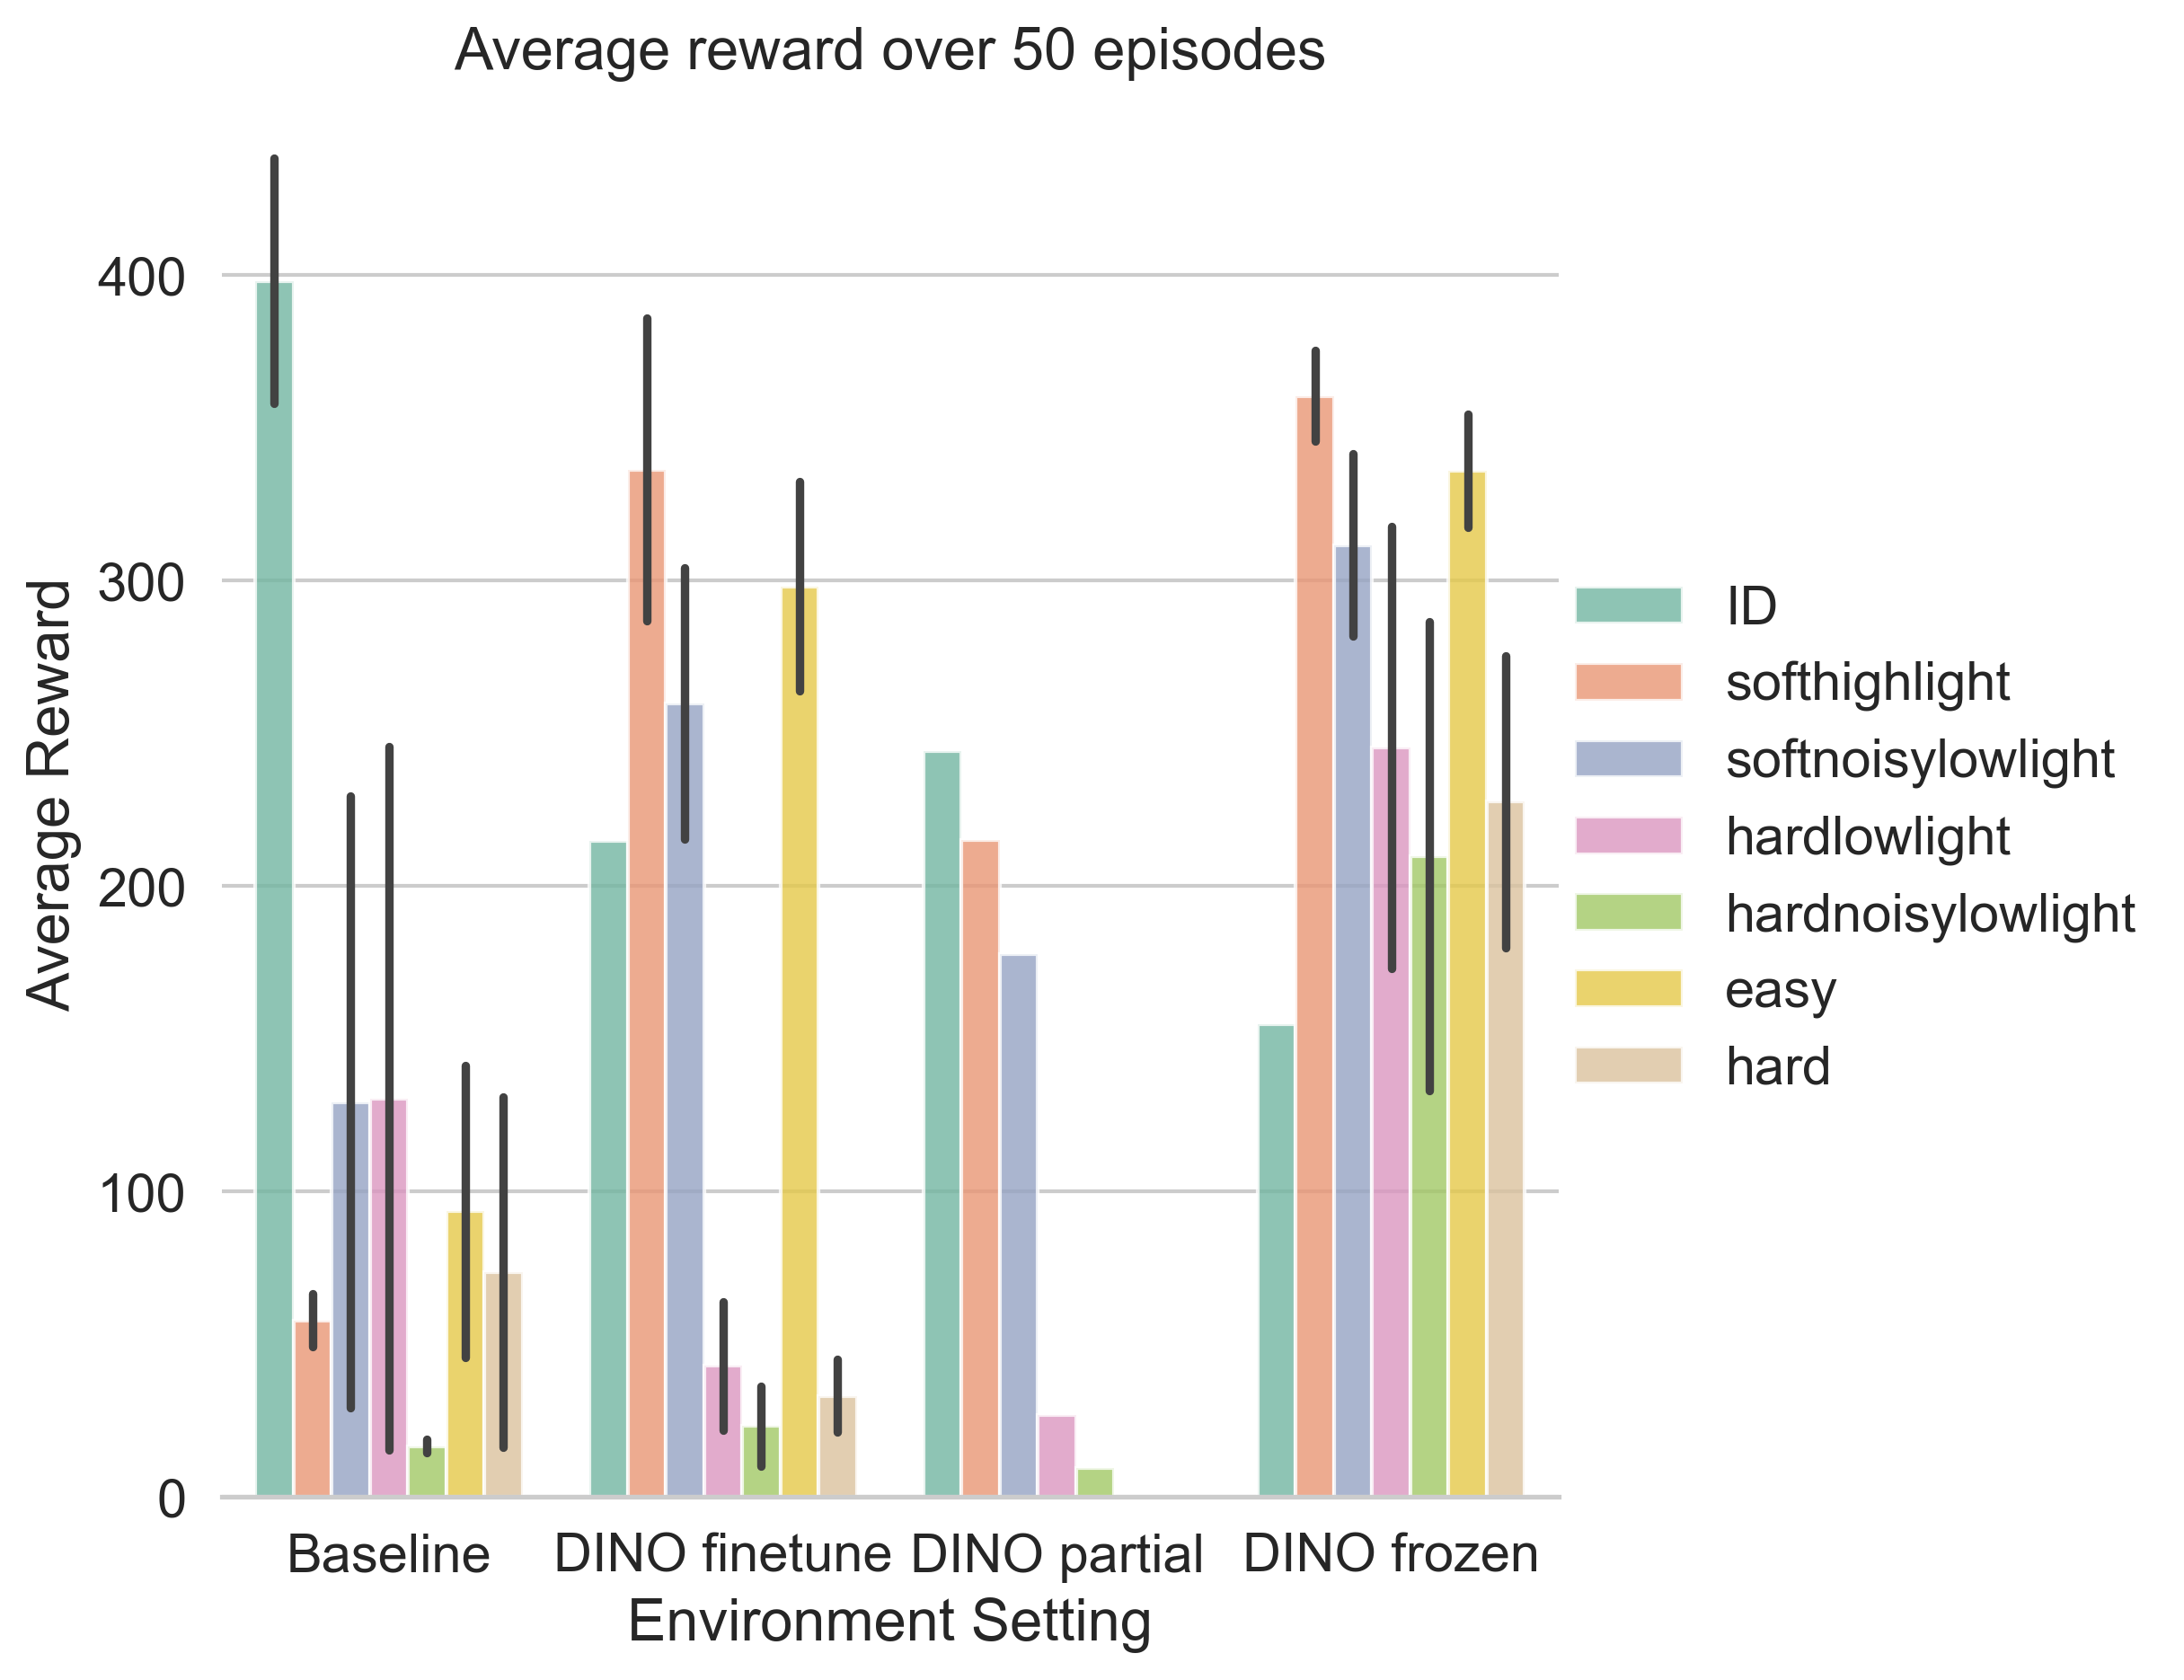

In [73]:
plot_carla(
    files_labels=[
        ("logdir/baseline_carla_eval_ID", "Baseline ID"),
        ("logdir/baseline_carla_eval_ID_1", "Baseline ID"),
        ("logdir/baseline_carla_eval_ID_2", "Baseline ID"),
        ("logdir/DINOFT_carla_eval_ID", "DINO finetune ID"),
        ("logdir/DINOPartial_carla_eval_ID", "DINO partial ID"),
        ("logdir/DINOFreeze_carla_eval_ID", "DINO frozen ID"),

        # ------------- soft high light -------------
        ("logdir/baseline_carla_eval_soft_high_light", "Baseline softhighlight"),
        ("logdir/baseline_carla_eval_soft_high_light_1", "Baseline softhighlight"),
        ("logdir/baseline_carla_eval_soft_high_light_2", "Baseline softhighlight"),

        ("logdir/DINOFT_carla_eval_soft_high_light", "DINO finetune softhighlight"),
        ("logdir/DINOFT_carla_eval_soft_high_light_1", "DINO finetune softhighlight"),
        ("logdir/DINOFT_carla_eval_soft_high_light_2", "DINO finetune softhighlight"),

        ("logdir/DINOPartial_carla_eval_soft_high_light", "DINO partial softhighlight"),

        ("logdir/DINOFreeze_carla_eval_soft_high_light", "DINO frozen softhighlight"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light_1", "DINO frozen softhighlight"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light_2", "DINO frozen softhighlight"),

        # ------------- soft low light -------------
        ("logdir/baseline_carla_eval_soft_noisy_low_light", "Baseline softnoisylowlight"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light_1", "Baseline softnoisylowlight"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light_2", "Baseline softnoisylowlight"),

        ("logdir/DINOFT_carla_eval_soft_noisy_low_light", "DINO finetune softnoisylowlight"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light_1", "DINO finetune softnoisylowlight"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light_2", "DINO finetune softnoisylowlight"),

        ("logdir/DINOPartial_carla_eval_soft_noisy_low_light", "DINO partial softnoisylowlight"),

        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light", "DINO frozen softnoisylowlight"),
        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINO frozen softnoisylowlight"),
        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINO frozen softnoisylowlight"),

        # ------------- hard low light -------------
        ("logdir/baseline_carla_eval_hard_low_light", "Baseline hardlowlight"),
        ("logdir/baseline_carla_eval_hard_low_light_1", "Baseline hardlowlight"),
        ("logdir/baseline_carla_eval_hard_low_light_2", "Baseline hardlowlight"),

        ("logdir/DINOFT_carla_eval_hard_low_light", "DINO finetune hardlowlight"),
        ("logdir/DINOFT_carla_eval_hard_low_light_1", "DINO finetune hardlowlight"),
        ("logdir/DINOFT_carla_eval_hard_low_light_2", "DINO finetune hardlowlight"),
        
        ("logdir/DINOPartial_carla_eval_hard_low_light", "DINO partial hardlowlight"),

        ("logdir/DINOFreeze_carla_eval_hard_low_light", "DINO frozen hardlowlight"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light_1", "DINO frozen hardlowlight"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light_2", "DINO frozen hardlowlight"),

        # ------------- hard noisy low light -------------
        ("logdir/baseline_carla_eval_hard_noisy_low_light", "Baseline hardnoisylowlight"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light_1", "Baseline hardnoisylowlight"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light_2", "Baseline hardnoisylowlight"),

        ("logdir/DINOFT_carla_eval_hard_noisy_low_light", "DINO finetune hardnoisylowlight"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light_1", "DINO finetune hardnoisylowlight"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light_2", "DINO finetune hardnoisylowlight"),

        ("logdir/DINOPartial_carla_eval_hard_noisy_low_light", "DINO partial hardnoisylowlight"),

        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light", "DINO frozen hardnoisylowlight"),
        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINO frozen hardnoisylowlight"),
        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINO frozen hardnoisylowlight"),

        # ------------- gathered results -------------
        ("logdir/baseline_carla_eval_soft_high_light", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_high_light_1", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_high_light_2", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light_1", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light_2", "Baseline easy"),

        ("logdir/baseline_carla_eval_hard_low_light", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_low_light_1", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_low_light_2", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light_1", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light_2", "Baseline hard"),

        ("logdir/DINOFT_carla_eval_soft_high_light", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_high_light_1", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_high_light_2", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light_1", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light_2", "DINO finetune easy"),

        ("logdir/DINOFT_carla_eval_hard_low_light", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_low_light_1", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_low_light_2", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light_1", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light_2", "DINO finetune hard"),

        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light_1", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light_2", "DINO frozen easy"),

        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light_1", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light_2", "DINO frozen hard"),
    ]
)

## Catastrophic Forgetting
In this experiment we train a K-Nearest Neighbours model on the output representation from the DinoV2 models before and after end-to-end finetuning with DreamerV3. In this small diagnostic test we trained using a 80:20 split from 20k ImageNet images.

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_3562/1506220593.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Catastrophic Forgetting: ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='Test Accuracy (%)'>

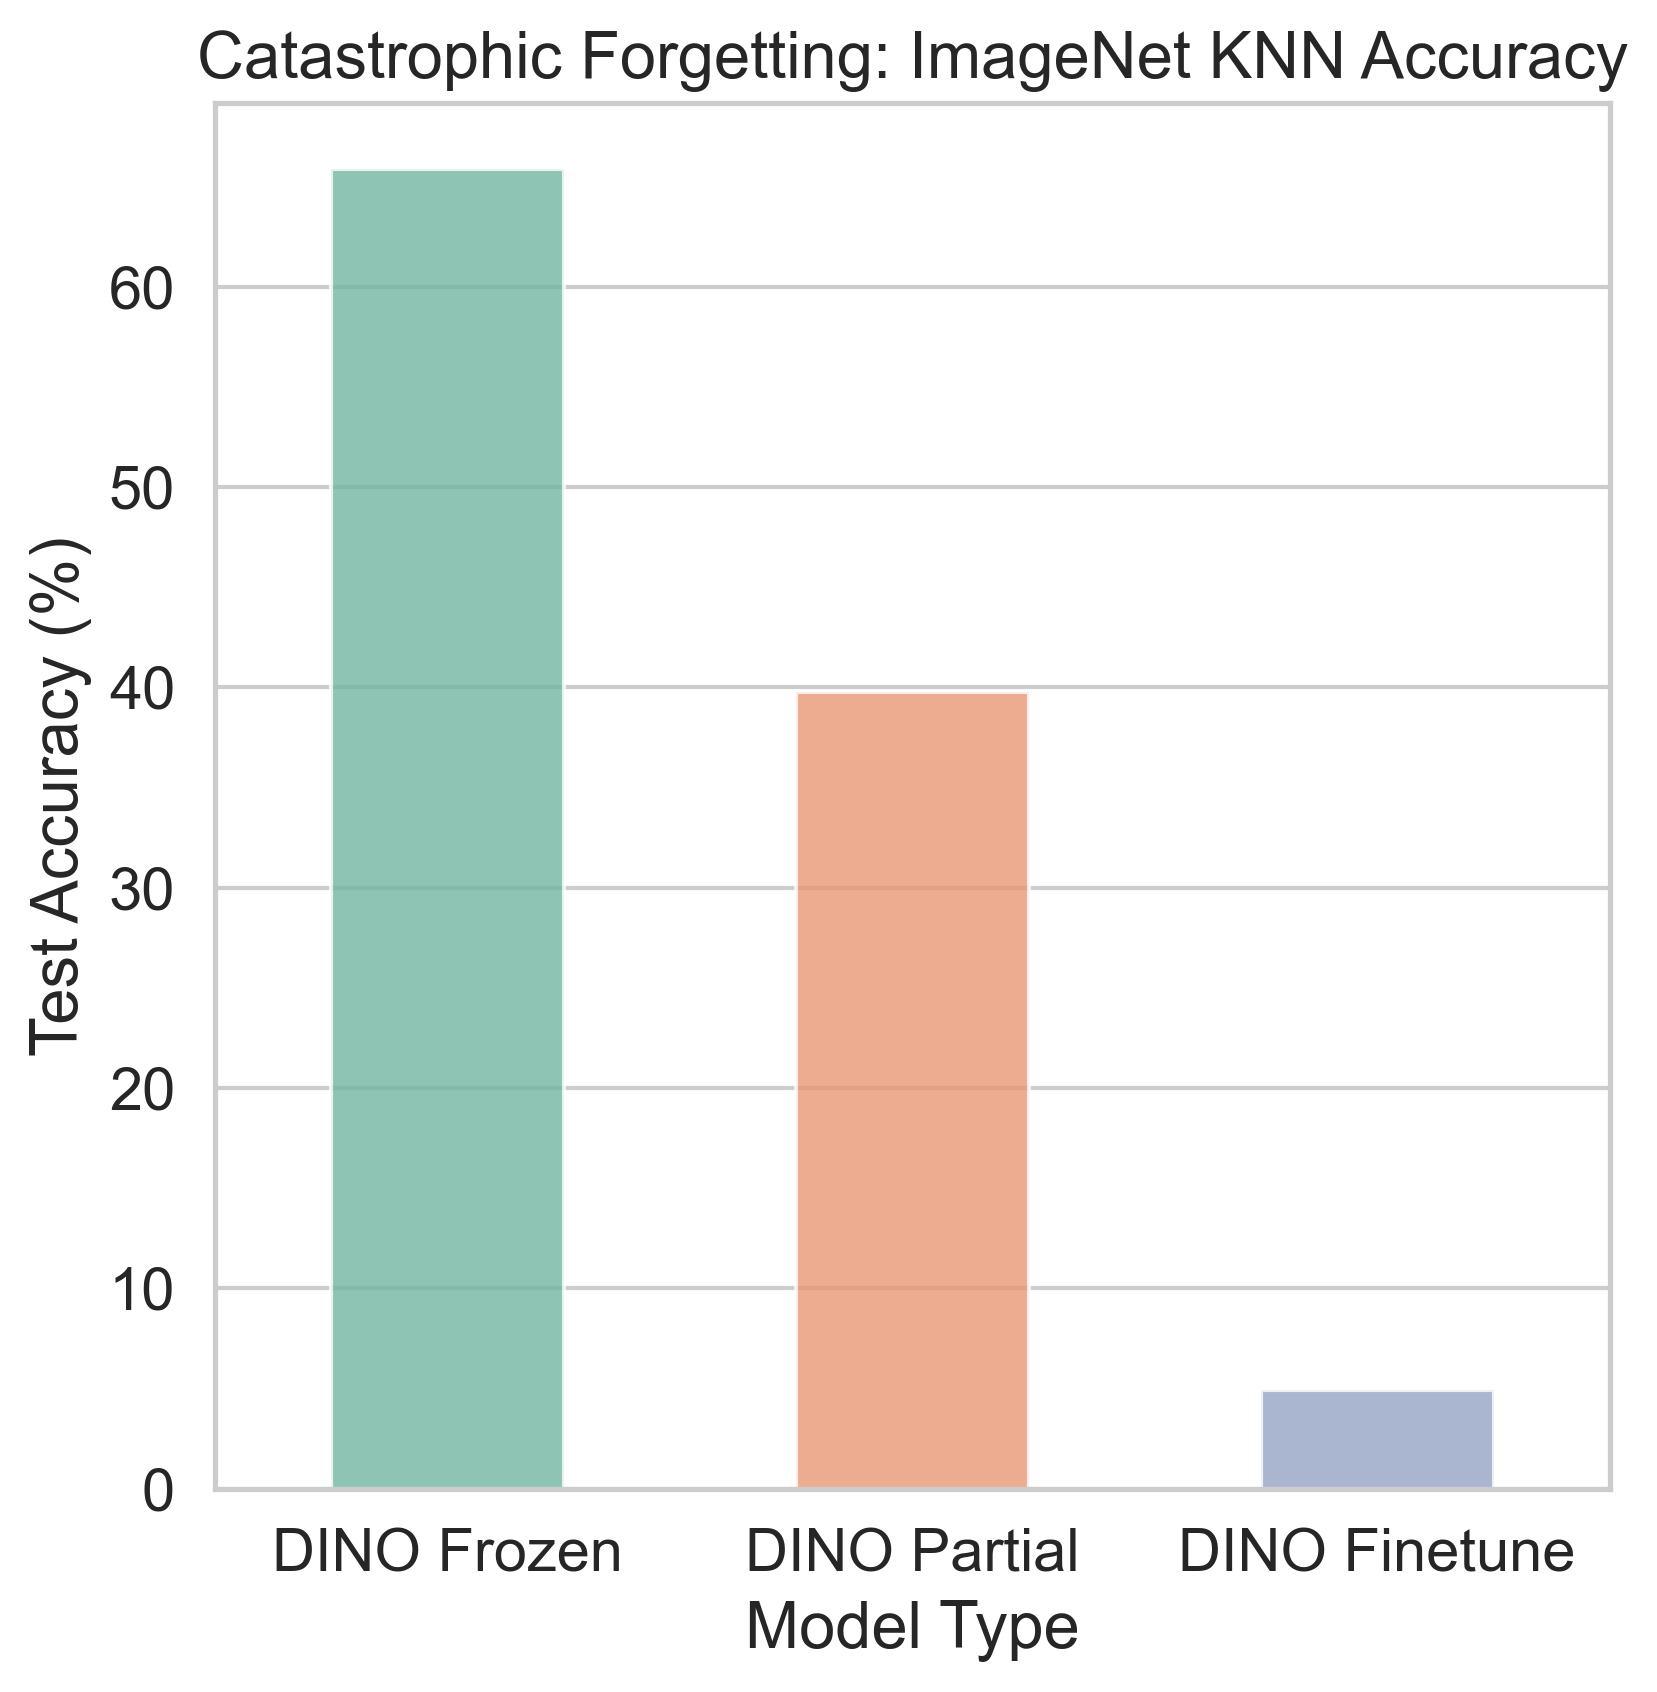

In [13]:
imagenet_knn_accuracy = [65.88, 39.77, 4.92]
imagenet_knn_labels = ["DINO Frozen", "DINO Partial", "DINO Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy (%)")
plt.title(f"Catastrophic Forgetting: ImageNet KNN Accuracy")
sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)